In [258]:
using RDatasets
using Base.Iterators
a = dataset("datasets", "anscombe")

,X1,X2,X3,X4,Y1,Y2,Y3,Y4
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,10,10,10,8,8.04,9.14,7.46,6.58
2,8,8,8,8,6.95,8.14,6.77,5.76
3,13,13,13,8,7.58,8.74,12.74,7.71
4,9,9,9,8,8.81,8.77,7.11,8.84
5,11,11,11,8,8.33,9.26,7.81,8.47
6,14,14,14,8,9.96,8.1,8.84,7.04
7,6,6,6,8,7.24,6.13,6.08,5.25
8,4,4,4,19,4.26,3.1,5.39,12.5
9,12,12,12,8,10.84,9.13,8.15,5.56


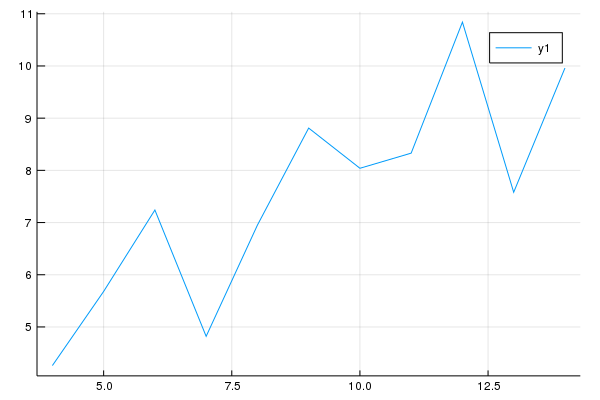

In [259]:
using Plots
sort!(a, [:X1])
plot(a[:X1], a[:Y1])

In [260]:
using Statistics
import Distributions: Normal
mean.(getindex.(Ref(a), [:X1,:Y1])), std.(getindex.(Ref(a), [:X1,:Y1])), cor(Matrix(a[[:X1, :Y1]]))[1,2]

([9.0, 7.50091], [3.31662, 2.03157], 0.81642051634484)

In [574]:
using Flux
using Flux.Tracker: forwarddiff
#randx = param(rand(size(a,1)) .* std(a[:X1]) .+ mean(a[:X1]))
#randy = param(rand(size(a,1)) .* std(a[:Y1]) .+ mean(a[:Y1]))
#randx, randy, a[:X1], a[:Y1]

mm= extrema(a[:Y1])
t1 = (mm[2]-mm[1])/4+ mm[1]
t2 = (mm[2]-mm[1])/4*2 + mm[1]
t3 = (mm[2]-mm[1])/4*3 + mm[1]
t1,t2

meanx = mean(a[:X1])
meany = mean(a[:Y1])
meanx, meany, t1, t2

stdx = std(a[:X1])
stdy = std(a[:Y1])

prex = rand(Normal(0,1), 141)
prey = rand(Normal(0,1), 141)

randx = param(prex .- mean(prex) .+ meanx)
randy = param(prey .- mean(prey) .+ meany)
randx, randy

([9.59889, 7.69938, 8.55715, 9.69192, 9.31036, 9.99248, 9.34965, 8.61463, 9.62538, 8.68799  …  9.84534, 9.26807, 8.63331, 7.09977, 10.1987, 8.48333, 10.549, 9.39422, 9.42058, 8.96025] (tracked), [7.90492, 7.04375, 8.83348, 6.07366, 7.83273, 7.09673, 9.8708, 7.29952, 6.31032, 6.72289  …  7.00047, 5.99008, 6.16438, 8.80314, 6.64408, 8.855, 8.07802, 8.44204, 7.6678, 7.78174] (tracked))

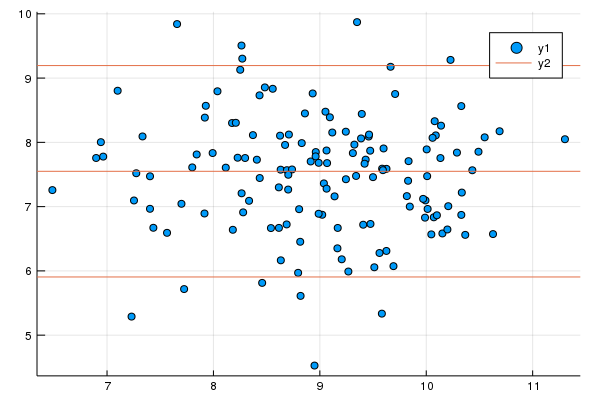

In [576]:
plot(Tracker.data(randx), Tracker.data(randy), seriestype=:scatter)
hline!([t1, t2, t3])

In [577]:
mean(Tracker.data.(randx)), mean(Tracker.data.(randy))
targetx = repeat(range(4, length = 47,stop = 14), outer = 3);
targety = repeat([t1,t2,t3], inner = 47);

In [580]:
using Flux.Tracker: update!

loss(targetx, targety) = begin
    index_considered = Int[]
    i = 1
    dist, index = findmin([(randx[i] - targetx)^2 + (randy[i]-targety)^2 for (targetx, targety) in zip(targetx, targety)])
    
    push!(index_considered, index)
    
    for i in 2:length(targetx)
        distances = [(randx[i] - targetx)^2 + (randy[i]-targety)^2 for (targetx, targety) in zip(targetx, targety)]        
        distances[index_considered] .= maximum(distances) + 1 
        
        distadd, index = findmin(distances)
    
        dist += distadd
        push!(index_considered, index)
    end
    
    dist
end

targetx_mean_loss(targetx) = begin
    mean((randx .- mean(targetx)).^2)
end

targety_mean_loss(targety) = begin
    mean((randy .- mean(targety)).^2)
end

targety_mean_loss (generic function with 1 method)

In [581]:
loss(targetx, targety)
gs = Tracker.gradient(() -> loss(targetx, targety), params(randx..., randy...))
gs2 = Tracker.gradient(() -> targetx_mean_loss(targetx), params(randx...))
gs3 = Tracker.gradient(() -> targety_mean_loss(targety), params(randy...))

Grads(...)


In [582]:
delta1 =gs[randx);
delta2 = getindex.(Ref(gs), randy);
delta3 = getindex.(Ref(gs2), randx);
delta4 = getindex.(Ref(gs3), randy);

findall(sign0.(delta1, delta3) .& sign0.(delta2, delta4))

sign0(x, y) = (x == 0) || (y == 0) || sign(x) == sign(y)

ErrorException: Object not tracked: 9.598894123696226

In [571]:
opt = ADAM()

function ok(targetx, targety) 
    println("ok")
    last_loss = float(9999)
    i = 0    
    while true
        i += 1
        delta1 = getindex.(Ref(gs), randx);
        delta2 = getindex.(Ref(gs), randy);
        #delta3 = getindex.(Ref(gs2), randx);
        #delta4 = getindex.(Ref(gs3), randy);
        
        # sample one
        #deltai = rand(findall(sign0.(delta1, delta3) .& sign0.(delta2, delta4)), 1)
        
        #update!(randx[deltai], -0.005(delta1[deltai]+delta3[deltai]))
        #update!(randy[deltai], -0.005(delta2[deltai]+delta4[deltai]))
        
        deltai = rand(1:length(targetx), 1)[1]        
        delta1[1:deltai-1] .= 0 
        delta1[deltai+1:end] .= 0     
        update!(randx, -0.01delta1)
        update!(randy, -0.01delta2)

        new_loss = Tracker.data(loss(targetx, targety))
        if new_loss < last_loss
            last_loss = new_loss
            #println(i)
            #println(loss(targetx, targety))
        else
            println(i)
            println(loss(targetx, targety))
            return mean(Tracker.data(randx)), mean(Tracker.data(randy))
        end
    end
end

ok (generic function with 2 methods)

In [572]:
ok(targetx, targety)

ok


KeyError: KeyError: key Tracker.Tracked{Float64}(0x00000000, Tracker.Call{getfield(Tracker, Symbol("##248#251")),Tuple{Tracker.Tracked{Float64},Tracker.Tracked{Float64}}}(getfield(Tracker, Symbol("##248#251"))(), (Tracker.Tracked{Float64}(0x00000000, Tracker.Call{Nothing,Tuple{}}(nothing, ()), true, 0.0), Tracker.Tracked{Float64}(0x00000000, Tracker.Call{getfield(Tracker, Symbol("##274#277")){Float64},Tuple{Nothing,Tracker.Tracked{Float64}}}(getfield(Tracker, Symbol("##274#277")){Float64}(-0.01), (nothing, Tracker.Tracked{Float64}(0x00000000, Tracker.Call{Nothing,Tuple{}}(nothing, ()), true, 0.0))), false, 0.0))), false, 0.0) not found

In [561]:
loss(targetx, targety)

842.6102491823183 (tracked)

In [354]:
loss(targetx, targety)

863.5114610707122 (tracked)

In [355]:
tx = Tracker.data.(randx)
ty = Tracker.data.(randy)
round.((mean(tx), meanx, mean(ty), meany), digits=2)

(9.0, 9.0, 7.5, 7.5)

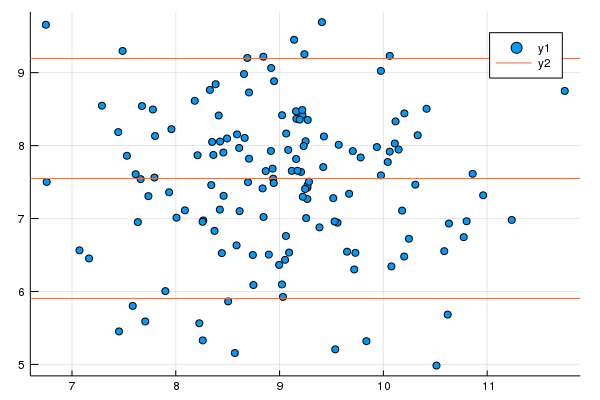

In [327]:
pred = DataFrame(x = Tracker.data.(randx), y = Tracker.data.(randy))

p = plot(pred[:x], pred[:y], seriestype=:scatter)
hline!([t1, t2, t3])
#plot!(targetx, targety, seriestype=:scatter)